# Assignment 3: Speech Emotion Recognition

## Downlaod the dataset and understand the format

For the SER, we will use the speech-emotion-recognition-en dataset from kaggle. This dataset consists of __four folders__ (Crema, Ravdess, Savee, Tess), we will only be working on the __Crema__ dataset.
The Crema dataset consistes of __7442 audio files__. Those audio files contain __different actors__ saying __different sentences__ with __different emotions__ and __different intensity__ (High, Low, Medium, xx)

In [1]:
import kagglehub
import os

crema_path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")
crema_path = os.path.join(crema_path, "Crema")

print("Path to dataset files:", crema_path)

Path to dataset files: /kaggle/input/speech-emotion-recognition-en/Crema


In [2]:
from collections import Counter

print(f'Number of audio files: {len(os.listdir(crema_path))}')

def extract_dataset_info(dataset_path):
    actor_ids = set()
    sentences = set()
    emotions = set()

    for file in os.listdir(dataset_path):
        if file.endswith('.wav'):
            parts = file.split('_')
            if len(parts) >= 4:
                actor_id = parts[0]
                sentence_id = parts[1]
                emotion_code = parts[2]

                actor_ids.add(actor_id)
                sentences.add(sentence_id)
                emotions.add(emotion_code)

    print(f"Number of unique actors: {len(actor_ids)}")
    print(f"Number of unique sentences: {len(sentences)}")
    print(f"    Sentences: {sorted(sentences)}")
    print(f"Number of unique emotions: {len(emotions)}")
    print(f"    Emotions: {sorted(emotions)}")

extract_dataset_info(crema_path)

Number of audio files: 7442
Number of unique actors: 91
Number of unique sentences: 12
    Sentences: ['DFA', 'IEO', 'IOM', 'ITH', 'ITS', 'IWL', 'IWW', 'MTI', 'TAI', 'TIE', 'TSI', 'WSI']
Number of unique emotions: 6
    Emotions: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [3]:
# pip install librosa
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Function to load and play the audio file
def play_audio(file_path):
    # Load the audio file as a floating point time series
    audio, sr = librosa.load(file_path, sr = None)       # sr -> sampling rate; None -> uses the original sr of the file

    # Play the audio file
    display(Audio(data=audio, rate=sr))

    return audio, sr

# Function to plot the waveform of the audio
def plot_waveform(audio, sr, emotion=None):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform for Emotion: {emotion}' if emotion else 'Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


=== Disgust (DIS) ===


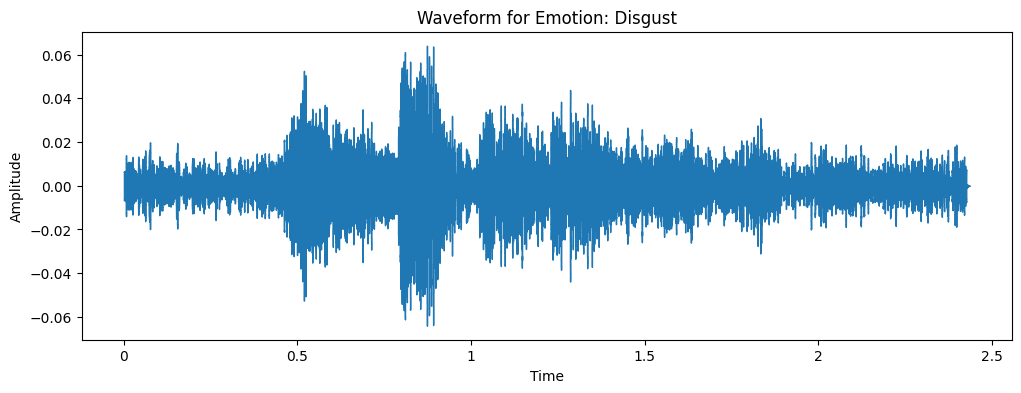


=== Happy (HAP) ===


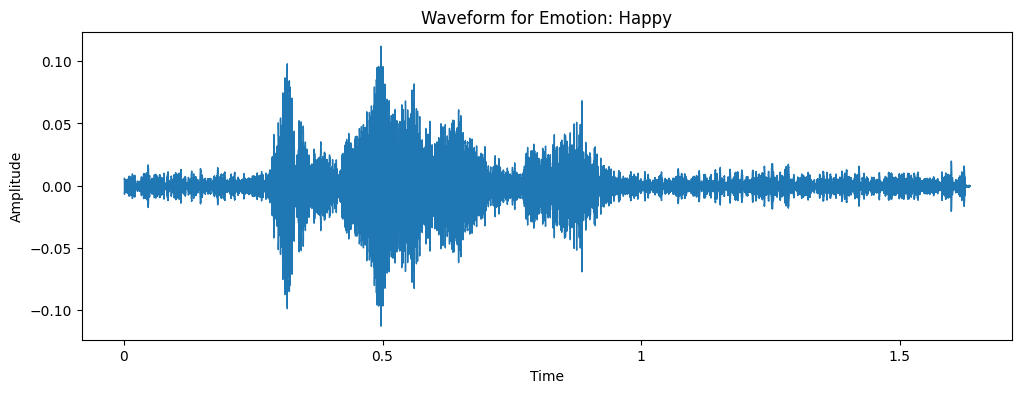


=== Sad (SAD) ===


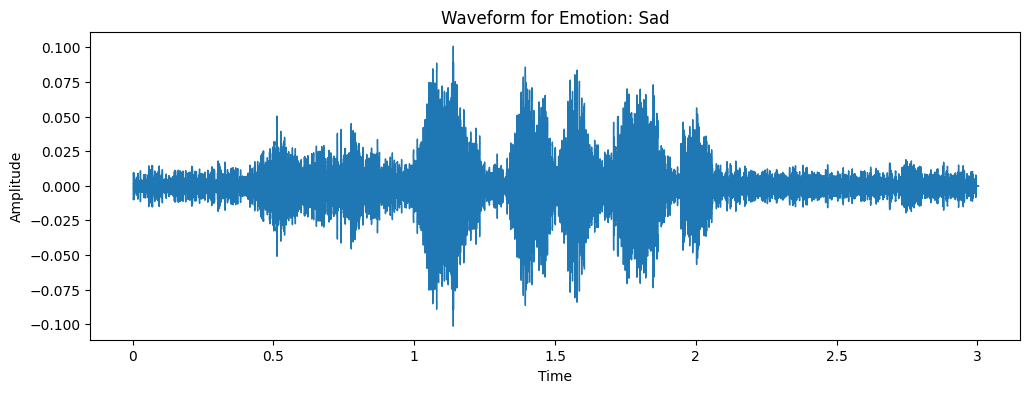


=== Neutral (NEU) ===


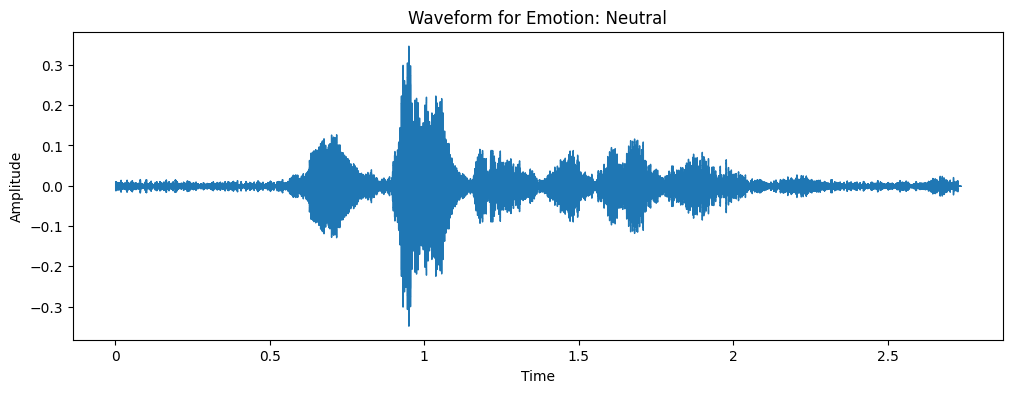


=== Fear (FEA) ===


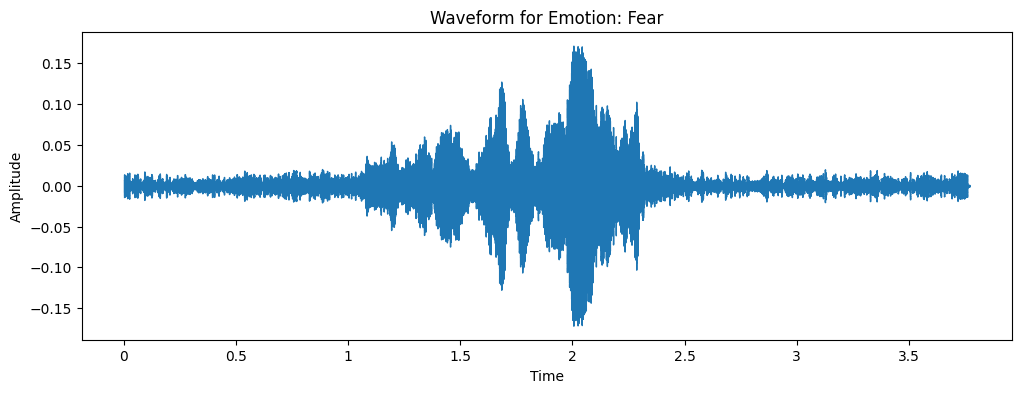


=== Anger (ANG) ===


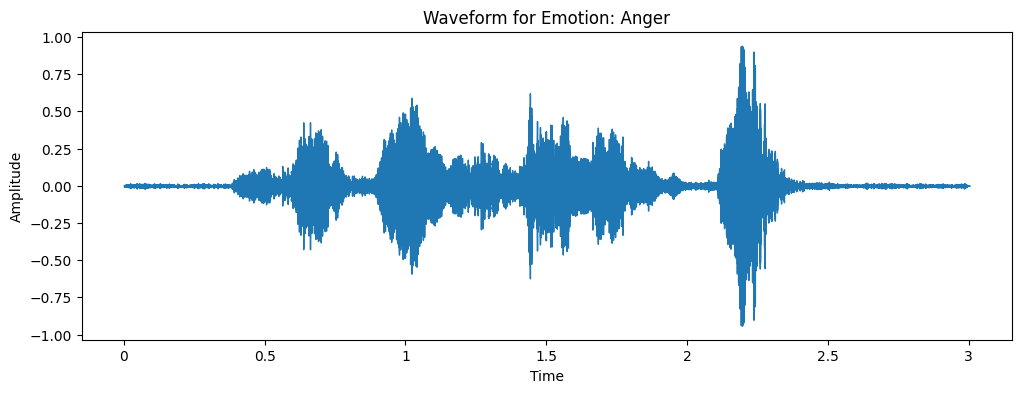

In [4]:
# Emotion mapping in CREMA
emotion_map = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

# Function that finds a sample for each emotion, loads it, plays it, and plot its wave form
def explore_emotion_classes(dataset_path, num_samples=1):
    # Get list of all audio files
    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    # Find a sample for each emotion
    samples = {}
    for file in audio_files:
        parts = file.split('_')
        info = {
            'actor': parts[0],                    # 1001, 1002, ...
            'sentence': parts[1],                 # DFA, IEO, IOM, ...
            'emotion': parts[2],                  # ANG, DIS, FEA, ...
            'intensity': parts[3].split('.')[0],  # HI, LO, MD, XX
            'filename': file
        }
        emotion = info['emotion']
        if emotion not in samples:     # Check if a sample exists for this emotion or not
            samples[emotion] = file
            if len(samples) == len(emotion_map):   # If found a sample for each emotion then break
                break

    # Process each sample
    for emotion_code, filename in samples.items():
        emotion_name = emotion_map.get(emotion_code, 'Unknown')
        print(f"\n=== {emotion_name} ({emotion_code}) ===")

        filepath = os.path.join(dataset_path, filename)
        audio, sr = play_audio(filepath)
        plot_waveform(audio, sr, emotion_name)

# Execute the exploration
explore_emotion_classes(crema_path)

## Create the Feature Space


### 1. Time Domain Features
#### (a) Zero Crossing Rate
Zero crossing rate is the rate of sign-changes of the signal during the duration of a particular frame.

In [5]:
def zero_crossing_rate(audio):
  zcr = librosa.feature.zero_crossing_rate(audio)
  return np.squeeze(zcr)              # Returns 1d array having size equal the number of frames

#### (b) Energy
Energy is the sum of squares of the signal values, normalized by the respective frame length.

In [6]:
def energy(audio):
  energy = librosa.feature.rms(y=audio)
  return np.squeeze(energy)           # Returns 1d array having size equal the number of frames

In [7]:
import numpy as np

# Function to extract the time domain features from the audio
def extract_time_features(audio, sr):

    features = np.array([])
    features = np.hstack((features,
                        zero_crossing_rate(audio),
                        energy(audio)))
    return features

In [9]:
import pandas as pd
def create_time_feature_dataframe(dataset_path):

    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    data = []
    labesl = []
    for file in audio_files:
        filepath = os.path.join(dataset_path, file)

        # Get the emotion from filename
        emotion = file.split('_')[2]

        # Load audio file
        audio, sr = librosa.load(filepath, sr=None)

        # Time-domain features (Zero crossing rate, Energy)
        time_features = extract_time_features(audio, sr)
        data.append(time_features)
        labesl.append(emotion)

    df = pd.DataFrame(data)
    df['emotion'] = labesl
    return df

time_df = create_time_feature_dataframe(crema_path)



In [10]:
time_df.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,emotion
0,0.016602,0.022949,0.030762,0.032227,0.029297,0.032715,0.033203,0.040527,0.041016,0.043945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
1,0.017578,0.024414,0.040527,0.041504,0.050293,0.054688,0.053711,0.054199,0.059570,0.064453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
2,0.020020,0.033691,0.041992,0.042969,0.056152,0.074707,0.073730,0.068848,0.053223,0.033691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
3,0.023438,0.030273,0.041504,0.036133,0.041016,0.041016,0.040527,0.045410,0.039551,0.041504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
4,0.020508,0.033691,0.043457,0.043457,0.037109,0.032227,0.034180,0.035156,0.046875,0.053711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS


In [11]:
time_df.fillna(0, inplace = True)
time_df.isna().sum().sum()

np.int64(0)

### 2. Frequency Domain Features
#### Mel Spectrogram

In [12]:
def extract_mel_spectrogram(audio, sr, n_mels=128, visualize=False):
    # Trim the silent parts
    audio, _ = librosa.effects.trim(audio, top_db=25)

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    if visualize:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        plt.show()

    return mel_spec_db      # Returns a 2d array of size n_mels * number of frames

In [13]:
# Function to extract all time and frequency domain features
def extract_freq_features(filepath):
    # Load audio file
    audio, sr = librosa.load(filepath, sr=None)

    # Frequency-domain features (Mel spectrogram)
    mel_spec = extract_mel_spectrogram(audio, sr)

    # Normalize the mel spectrogram
    epsilon = 1e-10
    mel_spec_mean = np.mean(mel_spec)
    mel_spec_std = np.std(mel_spec)

    # Handle case where std is zero
    if mel_spec_std < epsilon:
        mel_spec = mel_spec - mel_spec_mean
    else:
        mel_spec = (mel_spec - mel_spec_mean) / (mel_spec_std + epsilon)

    return {
        'filename': os.path.basename(filepath),
        'emotion': os.path.basename(filepath).split('_')[2],
        'mel_spectrogram': mel_spec
    }

In [14]:
import pandas as pd

# Function to create a feature dataframe of the audio dataset
def create_freq_feature_dataframe(dataset_path):

    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    data = []

    for file in audio_files:
        filepath = os.path.join(dataset_path, file)

        # Get the emotion from filename
        emotion = file.split('_')[2]

        # Extract features
        features = extract_freq_features(filepath)

        data.append(features)

    return pd.DataFrame(data)

feature_df = create_freq_feature_dataframe(crema_path)

In [15]:
feature_df.head()

,filename,emotion,mel_spectrogram
0,1028_TSI_DIS_XX.wav,DIS,"[[2.0600493, 2.1960082, 1.8995556, 1.7055526, ..."
1,1075_IEO_HAP_LO.wav,HAP,"[[1.0425919, 1.4528059, 1.8783413, 1.7705156, ..."
2,1084_ITS_HAP_XX.wav,HAP,"[[1.0071796, 0.69595855, 0.41182172, 0.3028291..."
3,1067_IWW_DIS_XX.wav,DIS,"[[0.52871746, 0.67717636, 0.63557607, 0.834233..."
4,1066_TIE_DIS_XX.wav,DIS,"[[1.3305007, 1.3701109, 1.5984623, 1.5330569, ..."


## Splitting the Dataset into Training, Validation, and Test Sets

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Prepare features
X_time = time_df.drop('emotion', axis=1)

max_frames = max(mel.shape[1] for mel in feature_df['mel_spectrogram'])   # Find max frames in dataset
X_mel = np.array([np.pad(mel, ((0, 0), (0, max_frames - mel.shape[1])), mode='constant')[..., np.newaxis]
    for mel in feature_df['mel_spectrogram']])                            # Pad all to max length
# X_mel = np.array(feature_df['mel_spectrogram'].tolist())

# Encode labels
le = LabelEncoder()
y = le.fit_transform(feature_df['emotion'])
y = to_categorical(y)



In [17]:
from sklearn.model_selection import train_test_split

# Split into train+val (70%) and test (30%)
X_time_train_val, X_time_test, y_train_val, y_test = train_test_split(X_time, y, test_size=0.3, random_state=42, stratify=y)

X_mel_train_val, X_mel_test, _, _ = train_test_split(X_mel, y, test_size=0.3, random_state=42, stratify=y)

# Split train+val into train (95%) and val (5%)
X_time_train, X_time_val, y_train, y_val = train_test_split(
    X_time_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)

X_mel_train, X_mel_val, _, _ = train_test_split(
    X_mel_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)

print(f"For Time Domain Features:\nTrain: {X_time_train.shape}, Val: {X_time_val.shape}, Test: {X_time_test.shape}")
print(f"For Frequency Domain Features:\nTrain: {X_mel_train.shape}, Val: {X_mel_val.shape}, Test: {X_mel_test.shape}")

For Time Domain Features:
Train: (4948, 314), Val: (261, 314), Test: (2233, 314)
For Frequency Domain Features:
Train: (4948, 128, 157, 1), Val: (261, 128, 157, 1), Test: (2233, 128, 157, 1)


## Build CNN Model
### 1. 1D CNN for Time Domain Features

In [18]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv1D(16, kernel_size=5, activation='relu', input_shape=(314, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv1D(16, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))
model.add(Dropout(0.3))

model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="same"))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(6, activation="softmax"))  # Adjust to the number of classes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_time_train, y_train, epochs=80, batch_size=64, validation_data=(X_time_val, y_val))

Epoch 1/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4412 - loss: 1.4503 - val_accuracy: 0.4253 - val_loss: 1.4747
Epoch 2/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4584 - loss: 1.4339 - val_accuracy: 0.3678 - val_loss: 1.5708
Epoch 3/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4498 - loss: 1.4256 - val_accuracy: 0.3295 - val_loss: 1.6641
Epoch 4/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4491 - loss: 1.4197 - val_accuracy: 0.3257 - val_loss: 1.6356
Epoch 5/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4389 - loss: 1.4506 - val_accuracy: 0.3602 - val_loss: 1.5077
Epoch 6/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4609 - loss: 1.4220 - val_accuracy: 0.3640 - val_loss: 1.5700
Epoch 7/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4668 - loss: 1.4204 - val_accuracy: 0.3563 - val_loss: 1.5531
Epoch 8/40
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4717 - loss: 1.4155 - val_accuracy: 0.3602 - v

In [24]:
test_loss, test_acc = model.evaluate(X_time_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4414 - loss: 1.4678
Test accuracy: 45.05%


### 2. 2D CNN for Frequency Domain Features

## Evaluation and Comparison